Get to your edited low-res clip


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
DRIVE_PATH = '/content/gdrive/My\ Drive/Curb'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/Curb'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [3]:
%cd Curb
!apt install -y --no-install-recommends ffmpeg
!pip install ffpb

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [4]:
from IPython.display import HTML, display, clear_output
from base64 import b64encode
def play(path):
  mp4 = open(path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
    <source src="%s" type="video/mp4">
  </video>
  """ % data_url)
%cd COMPRESSEDVIDEO
compressed_vids = os.listdir()

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb/COMPRESSEDVIDEO


In [5]:
import pickle

In [6]:
%cd ..

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb


In [7]:
scenes = pickle.load(open("scenes.pkl", "rb" ))

In [8]:
%cd AUDIO

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb/AUDIO


In [9]:
def play_audio(path):
  wav = open(path,'rb').read(10000000)
  data_url = "data:audio/wav;base64," + b64encode(wav).decode()
  return HTML("""
  <audio width=400 controls>
    <source src="%s" type="audio/wav">
  </audio>
  """ % data_url)

In [10]:
audio = pickle.load(open("audio_to_scene.pkl", "rb" ))
%cd ..

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb


In [11]:
%cd SCENE1

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb/SCENE1


In [12]:
import cv2
import numpy as np
from tqdm.notebook import tqdm
from math import floor

In [13]:
#New methodology: divide the screen up into n boxes, and sum the pixels in them. 

In [14]:
def blockmean(n, a):
  return np.array(cv2.resize(a, dsize=(n, n), interpolation=cv2.INTER_CUBIC))

In [15]:
compressed_info = []
n = 100
for scene in scenes[1]:
  cap = cv2.VideoCapture(scene)
  fps = cap.get(cv2.CAP_PROP_FPS)
  framecount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frames = []
  for i in tqdm(range(framecount)):
      ret, frame = cap.read()
      frame = np.array(frame) 
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
      else:
        frames.append(blockmean(n, frame))
  compressed_info.append(np.array(frames))


In [16]:
cap = cv2.VideoCapture("scene1.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
framecount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
compressed_edited = []
for i in tqdm(range(framecount)):
    ret, frame = cap.read()
    frame = np.array(frame) 
    if cv2.waitKey(1) & 0xFF == ord('q') or frame.shape == ():
        break
    else:
      compressed_edited.append(blockmean(n, frame))
compressed_edited = np.array(compressed_edited)

In [17]:
full_frames = []
for edited_frame in tqdm(compressed_edited):
  minframe = (float("inf"), None)
  for v, vid in enumerate(compressed_info):
    for f, frame in enumerate(vid):
      s = np.sum(np.abs(edited_frame.astype(float) - frame.astype(float)))
      if s < minframe[0]:
        minframe = (s,(v,f))
  full_frames.append(minframe)


In [18]:
#Regarding EFFECTS: cropping, for example. Shit. Maybe gonna take care of it in post??

In [19]:
def fmt(inp):
  hr = (inp // 3600)
  mi = (inp % 3600) // 60
  se = round(inp % 60,2)

  return str(int(hr)).zfill(2) + ":" + str(int(mi)).zfill(2) + ":" + str(se).zfill(0)

In [20]:
import matplotlib.pyplot as plt

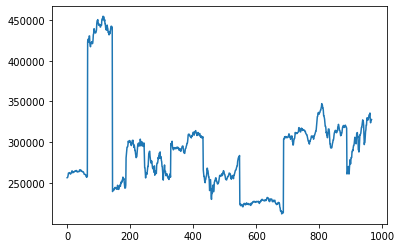

In [21]:
plt.plot([i[0] for i in full_frames])

In [31]:
cuts = []
e_flag = True
for f, i in enumerate(full_frames):
  if i[0]/(10**6) > .6:
    if e_flag:
      e_flag = False
      cuts.append((f/fps,"ERROR",i[1][1]/fps))

  elif i[1][0] != full_frames[f-1][1][0]:
    e_flag = True
    cuts.append((f/fps,i[1][0],i[1][1]/fps))



In [33]:
cuts

[(0.0, 7, 0.16683333333333333),
 (2.168833333333333, 2, 2.0020000000000002),
 (4.8048, 7, 10.043366666666667),
 (6.239566666666667, 1, 9.009),
 (8.074733333333333, 7, 17.083733333333335),
 (10.977633333333333, 2, 7.5075),
 (14.4144, 9, 4.3043000000000005),
 (18.284933333333335, 6, 11.5115),
 (22.922900000000002, 2, 10.110100000000001),
 (26.092733333333335, 4, 10.2102),
 (29.6296, 1, 17.9179)]

In [24]:
#Ok, now let's experimentally put these things together

In [25]:
%cd ..
!mkdir SCENE1/FULLRES

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb


In [38]:
for i in range(len(cuts)-1):
  !yes | ffpb -i {scenes[1][cuts[i][1]]} -ss {fmt(cuts[i][2])} -t {fmt(cuts[i+1][0] - cuts[i][0])} -async 1 SCENE1/FULLRES/{str(i).zfill(3)}.MP4


P1022104.MOV:   6% 48/864 [00:32<09:04,  1.50 frames/s]
P1022099.MOV:   8% 48/576 [00:56<10:25,  1.18s/ frames]
P1022104.MOV:   3% 24/864 [00:50<29:16,  2.09s/ frames]
P1022098.MOV:   4% 24/600 [00:59<23:52,  2.49s/ frames]
P1022104.MOV:   6% 48/864 [01:42<28:57,  2.13s/ frames]
P1022099.MOV:  12% 72/576 [01:21<09:31,  1.13s/ frames]
P1022106.MOV:  18% 72/408 [01:17<05:59,  1.07s/ frames]
P1022103.MOV:   8% 96/1176 [01:35<17:53,  1.01 frames/s]
P1022099.MOV:  12% 72/576 [01:20<09:21,  1.12s/ frames]
P1022101.MOV:  18% 72/408 [01:31<07:05,  1.27s/ frames]


In [39]:
%cd SCENE1/FULLRES/

/content/gdrive/.shortcut-targets-by-id/18G5ng6QyXM8IgyHj_VL7EBw0LEpt3YIU/Curb/SCENE1/FULLRES


In [43]:
%ls

000.MP4  002.MP4  004.MP4  006.MP4  008.MP4  do.txt
001.MP4  003.MP4  005.MP4  007.MP4  009.MP4  output.MP4


In [41]:
with open('do.txt', 'w+') as f:
  for i in range(len(cuts)-1):
    f.write("file '" + str(i).zfill(3) + ".MP4'\n")

In [44]:
!yes | ffmpeg -f concat -i do.txt -c copy output.MP4


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib